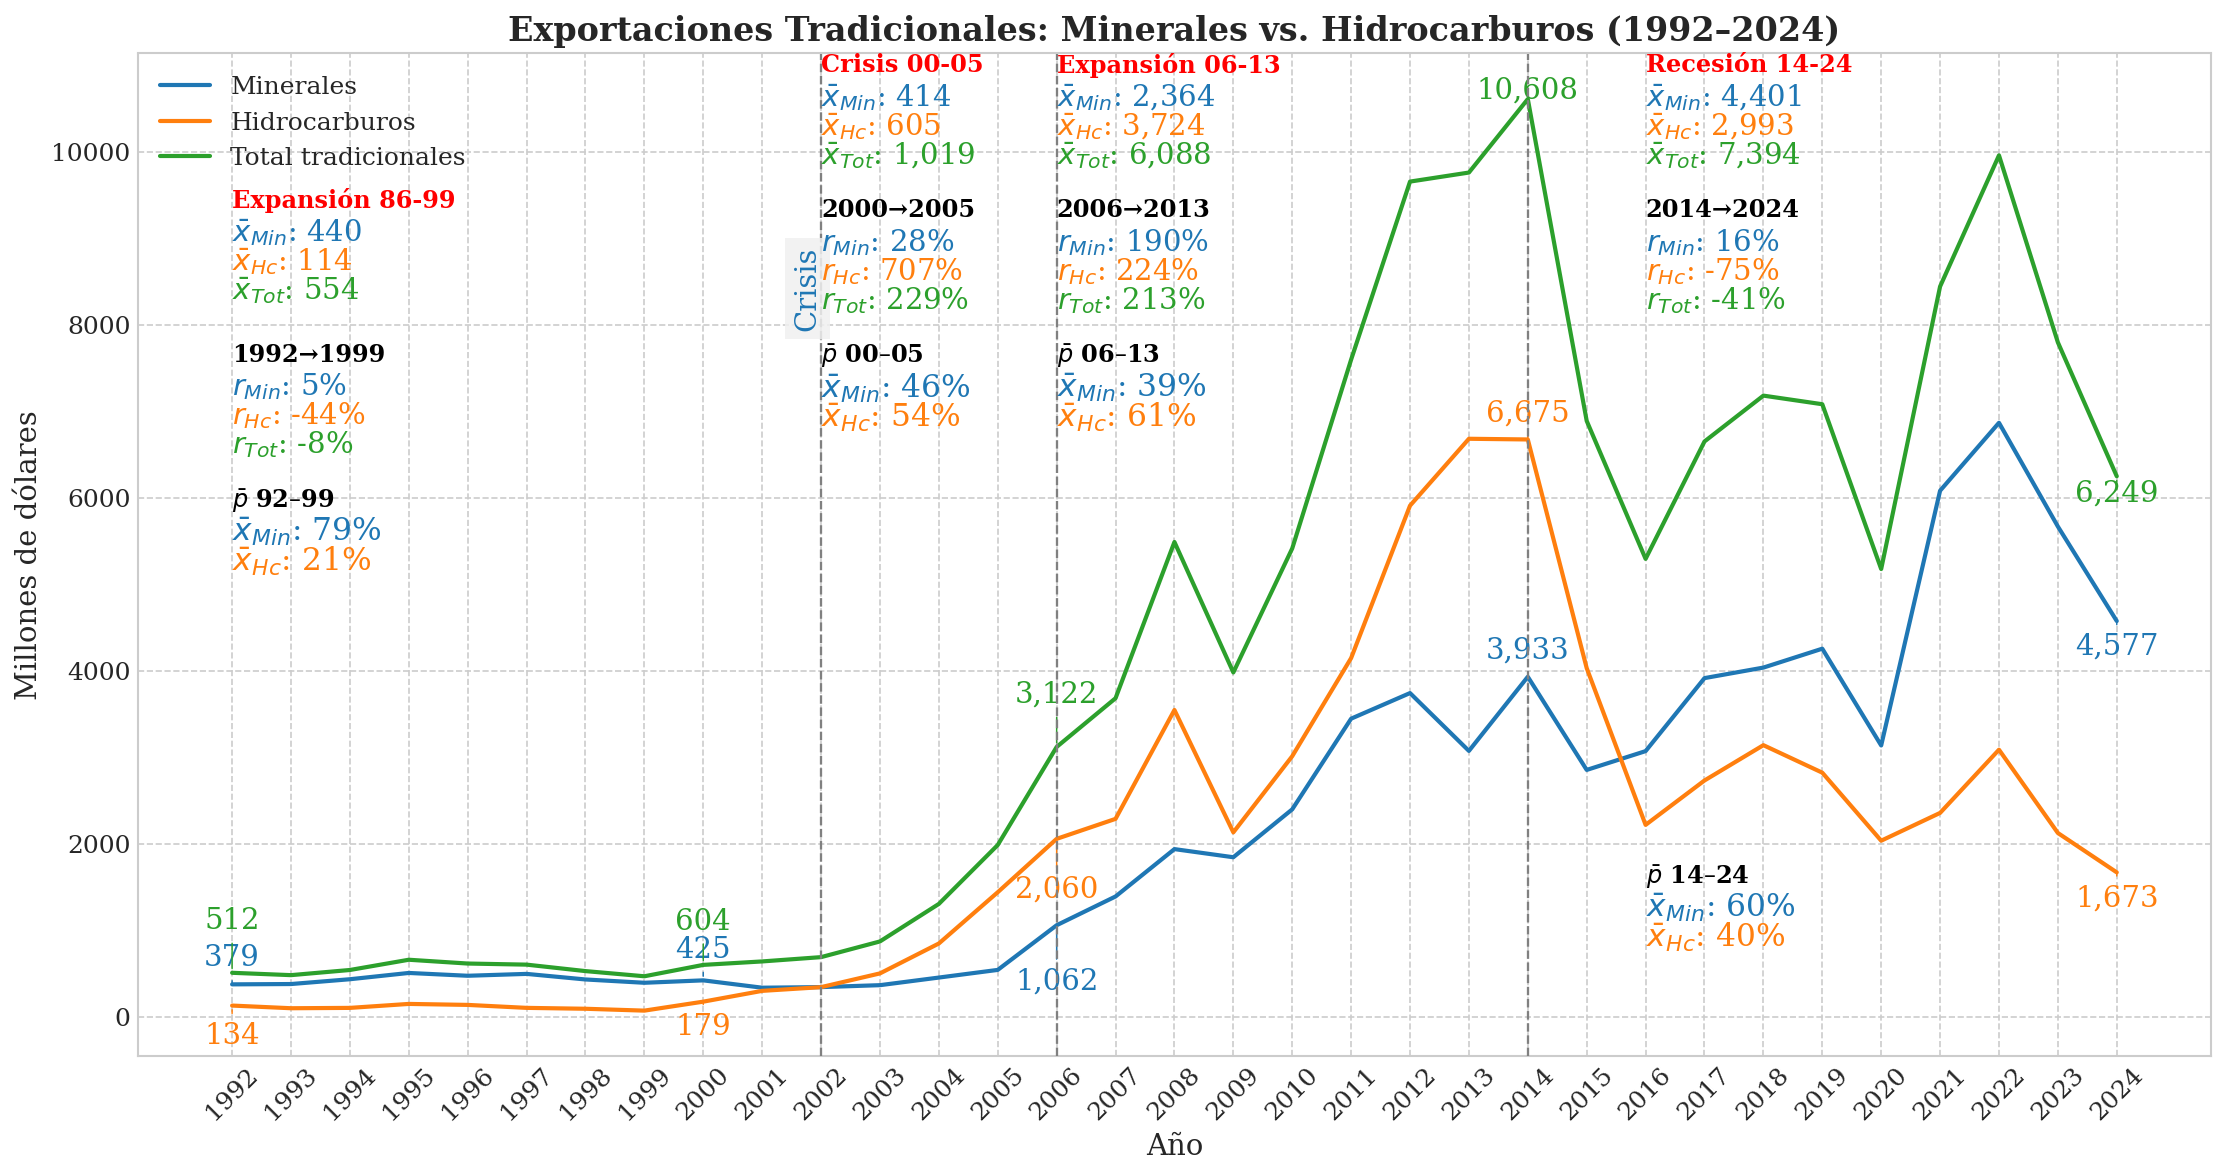

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi, add_participation_cycle_boxes
)

# ── 0.  Tramos de ciclo ──────────────────────────────────────────────
EXPANSION_86_99   = slice(1986, 1999)
ACUMULACION_06_13 = slice(2006, 2013)
RECESION_14_24    = slice(2014, 2024)

periods = {
    "Expansión 86-99": EXPANSION_86_99,
    "Crisis 00-05": slice(2000, 2005),
    "Expansión 06-13": ACUMULACION_06_13,
    "Recesión 14-24":  RECESION_14_24,
}

# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 12,
    'axes.titlesize': 16,   'axes.labelsize': 14,
    'grid.linestyle': '--', 'lines.linewidth': 2,
    'figure.dpi': 150,      'savefig.bbox': 'tight'
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM exportaciones_tradicionales', conn)
            .set_index('año')
            .sort_index())
    df['total'] = df['minerales'] + df['hidrocarburos']
# ── 3. Estadísticas por ciclo ────────────────────────────────────────
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in periods.items()
}

# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {
    1952: "Crisis", 1956: "Expansión", 1970: "Recesión",
    1982: "Crisis", 1986: "Expansión", 2002: "Crisis",
    2006: "Expansión", 2014: "Recesión"
}
hitos_offset = {a: 0.8 for a in hitos_v}          # igual que antes
medias_offset = {
    "Expansión 86-99": (1992, 0.86),
    "Crisis 00-05": (2002, 1.0),
    "Expansión 06-13": (2006, 1.0),
    "Recesión 14-24":  (2016, 1.0),
}

anot_years = [1992, 2000, 2006, 2014, 2024]
annotation_offsets = {
    'minerales':     {
        1992: (0, 300),
        2000: (0, 350),
        2006: (0, -650),
        2014: (0, 300),
        2024: (0, -300),
    },
    'hidrocarburos': {
        1992: (0, -350),
        2000: (0, -290),
        2006: (0, -590),
        2014: (0, 300),
        2024: (0, -300),
    },
    'total':         {
        1992: (0, 600),
        2000: (0, 500),
        2006: (0, 600),
        2014: (0, 100),
        2024: (0, -200),
    }
}

annotation_tasas_offsets = {
    "1992-1999": (1992, 0.70),
    "2000-2005": (2002, 0.85),
    "2006-2013": (2006, 0.85),
    "2014-2024": (2016, 0.85),
}
participation_offsets = {
    "1992-1999": (1992, 0.55),
    "2000-2005": (2002, 0.7),
    "2006-2013": (2006, 0.7),
    "2014-2024": (2016, 0.16),
}

# ── 5. Gráfico ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df.index, df['minerales'],
        label='Minerales',    color='#1f77b4')
ax.plot(df.index, df['hidrocarburos'],
        label='Hidrocarburos', color='#ff7f0e')

ax.plot(df.index, df['total'],
        label='Total tradicionales', color='#2ca02c')

# ── 6. Hitos ─────────────────────────────────────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset)

# ── 7. Anotaciones de medias, valores y tasas ────────────────────────
abbr_map = {'minerales': 'Min', 'hidrocarburos': 'Hc', 'total': 'Tot'}
component_colors = {'minerales': '#1f77b4', 'hidrocarburos': '#ff7f0e', 'total': '#2ca02c'}

y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
cols = ['minerales', 'hidrocarburos', 'total']

add_cycle_means_multi(ax, cycle_stats, medias_offset,
                      abbr_map, component_colors, line_spacing)

add_year_value_annotations(ax, df, anot_years,
                           cols, annotation_offsets, component_colors, arrow_lw=0.7)

periodos = [(1992, 1999), (2000, 2005), (2006, 2013), (2014, 2024)]
add_period_growth_annotations_multi(ax, df, periodos,
    cols, annotation_tasas_offsets, component_colors, abbr_map)

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    ['minerales', 'hidrocarburos'],  # sólo minerales e hidrocarburos
    'total',                   # columna total sobre la que se calcula %
    participation_offsets,
    abbr_map=abbr_map,
    colors=component_colors
)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"Exportaciones Tradicionales: Minerales vs. Hidrocarburos ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de dólares")
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "exportaciones_tradicionales.png"))
plt.show()
